In [ ]:
import warnings
warnings.filterwarnings("ignore")
import os
import gc
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.constraints import Constraint
import tensorflow.keras.backend as K

gc.enable()

In [ ]:
dataset_url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSDS500/data")

70763455/70763455 [==============================] - 5s 0us/step


In [ ]:
test_paths = glob(root_dir + "/images/test/" + "*.jpg")

In [ ]:
crop_size = 96  # HR size
upscale_factor = 4
input_size = crop_size // upscale_factor
batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

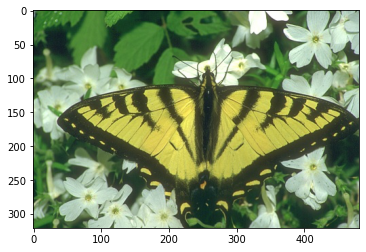

In [ ]:
image = Image.open(root_dir + "/images/train/35010.jpg")
plt.imshow(image)

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    batch_size=None,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode=None,
)

valid = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    batch_size=None,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode=None,
)

Found 500 files belonging to 1 classes.
Using 400 files for training.
Found 500 files belonging to 1 classes.
Using 100 files for validation.


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(input_size, input_size, interpolation='area'),
    # layers.Rescaling(1./255)
    layers.Rescaling(1./127.5, offset=-1)  # [-1,1]
])

rescale = tf.keras.Sequential([
    # layers.Rescaling(1./255)
    layers.Rescaling(1./127.5, offset=-1)
])

data_augmentation = tf.keras.Sequential([
        layers.RandomCrop(crop_size, crop_size),
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
])

def prepare(ds, shuffle=False, augment=False):
    if augment:
        ds = ds.map(lambda x: (data_augmentation(x, training=True)), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x: (resize_and_rescale(x), rescale(x)), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(batch_size)

    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# helper functions

def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)  # 255 for model output range [0,255]

def denormalize(inputs):  # from [0,1]
    return tf.cast(tf.clip_by_value(inputs * 255, 0, 255), dtype=tf.uint8)

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

In [ ]:
def denormalize(inputs):  # from [-1,1]
    return tf.cast(tf.clip_by_value((inputs * 0.5 + 0.5) * 255, 0, 255), dtype=tf.uint8)

In [ ]:
train_ds = prepare(train, shuffle=True, augment=True)
valid_ds = prepare(valid)

In [ ]:
for p in train_ds.take(1):
    ims, tars = p

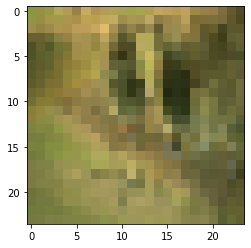

In [ ]:
plt.imshow(denormalize(ims[0]).numpy())

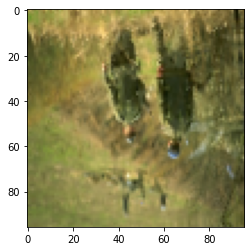

In [ ]:
plt.imshow(denormalize(tars[0]).numpy())

In [ ]:
# vgg19 model for computing loss

def vgg_model():
    
    vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(crop_size, crop_size, 3))
    #vgg19.trainable = False
    #for layer in vgg19.layers:
    #    layer.trainable = False
    model = tf.keras.Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)  # [14,14,512]
    #model.trainable = False

    return model

def perceptual_loss(model):

    def loss(y_true, y_pred):
        y_true_ = tf.cast(denormalize(y_true), dtype=tf.float32)  # set in range [0,255] as expected by vgg19
        y_pred_ = tf.cast(denormalize(y_pred), dtype=tf.float32)
        y_true_ = tf.keras.applications.vgg19.preprocess_input(y_true_)  # preprocess batch for vgg19
        y_pred_ = tf.keras.applications.vgg19.preprocess_input(y_pred_)

        return K.mean(K.square(model(y_true_) - model(y_pred_)))  # MSE loss
    
    return loss

In [ ]:
# generator

def generator():
    def residual_block(inputs, filters):
        out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(inputs)
        out = layers.BatchNormalization(momentum=0.8)(out)
        out = layers.PReLU(shared_axes=[1,2])(out)
        out = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(out)
        out = layers.BatchNormalization(momentum=0.8)(out)
        out = layers.Add()([inputs, out])
        return out

    def upsample(inputs):
        out = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(inputs)
        
        out = layers.Lambda(pixel_shuffle(scale=2))(out)
        # out = layers.UpSampling2D(size=2)(out)  # interpolation

        # out = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding="same")(inputs)  # learned inverse conv
        # out = layers.LeakyReLU(alpha=0.2)(out)

        out = layers.PReLU(shared_axes=[1,2])(out)
        return out

    lr_image = layers.Input(shape=(input_size, input_size, 3))
    conv1 = layers.Conv2D(64, kernel_size=9, strides=1, padding='same')(lr_image)
    conv1 = layers.PReLU(shared_axes=[1,2])(conv1)

    res = residual_block(conv1, 64)
    for _ in range(15):
        res = residual_block(res, 64)

    conv2 = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(res)
    conv2 = layers.BatchNormalization(momentum=0.8)(conv2)
    conv2 = layers.Add()([conv1, conv2])

    up1 = upsample(conv2)
    up2 = upsample(up1)
    # sigmoid [0,1] out pixel range if 1./255.; tanh [-1,1] out if 1/127.5 - 1 
    hr_image = layers.Conv2D(3, kernel_size=9, strides=1, padding='same', activation='tanh')(up2)  

    return tf.keras.Model(inputs=lr_image, outputs=hr_image, name="generator")

In [ ]:
class SpectralNorm(Constraint):
    '''
    apply to all discriminator layers
    '''
    def __init__(self, power_iters=5):
        self.n_iters = power_iters

    def __call__(self, w):
        flattened_w = tf.reshape(w, [w.shape[0], -1])
        u = tf.random.normal([flattened_w.shape[0]])
        v = tf.random.normal([flattened_w.shape[1]])
        for i in range(self.n_iters):
            v = tf.linalg.matvec(tf.transpose(flattened_w), u)
            v = self.l2_normalize(v)
            u = tf.linalg.matvec(flattened_w, v)
            u = self.l2_normalize(u)
        sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
        return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

    @staticmethod
    def l2_normalize(x, eps=1e-12):
        '''
        Scale input by the inverse of it's euclidean norm
        '''
        return x / tf.linalg.norm(x + eps)

In [ ]:
# discriminator

def discriminator_block(x_in, num_filters, strides=1, batchnorm=True, momentum=0.8, spectral=True):
    if spectral:
        x = layers.Conv2D(num_filters, kernel_size=3, strides=strides, padding='same', kernel_constraint=SpectralNorm())(x_in)
    else:
        x = layers.Conv2D(num_filters, kernel_size=3, strides=strides, padding='same')(x_in)
    if batchnorm:
        x = layers.BatchNormalization(momentum=momentum)(x)
    return layers.LeakyReLU(alpha=0.2)(x)


def discriminator(num_filters=64):
    x_in = tf.keras.Input(shape=(crop_size, crop_size, 3))

    x = discriminator_block(x_in, num_filters, batchnorm=False)
    x = discriminator_block(x, num_filters, strides=2)

    x = discriminator_block(x, num_filters * 2)
    x = discriminator_block(x, num_filters * 2, strides=2)

    x = discriminator_block(x, num_filters * 4)
    x = discriminator_block(x, num_filters * 4, strides=2)

    x = discriminator_block(x, num_filters * 8)
    x = discriminator_block(x, num_filters * 8, strides=2)

    x = layers.Flatten()(x)  # it is argued that FCN maybe more effective, here set as in original paper

    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=x_in, outputs=x, name="discriminator")

In [ ]:
class SRGAN(tf.keras.Model):
    def __init__(self, smooth=0.1):
        super(SRGAN, self).__init__()
        self.generator = generator()
        self.discriminator = discriminator()
        self.vgg = vgg_model()
        self.binary_loss_fn_g = tf.keras.losses.BinaryCrossentropy()  # as option use MSELoss
        self.binary_loss_fn_d = tf.keras.losses.BinaryCrossentropy(label_smoothing=smooth)
        # self.gen_loss_fn = perceptual_loss(self.vgg)
        self.gen_loss_fn = tf.keras.losses.MeanAbsoluteError()  # MeanSquaredError()

    def compile(self, d_optimizer, g_optimizer, *args, **kwargs):
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer

        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.psnr = tf.keras.metrics.Mean(name="psnr")
        super(SRGAN, self).compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric, self.psnr]

    def train_step(self, inputs):
        lr_images, hr_images = inputs

        with tf.GradientTape() as g_tape:
            gen_images = self.generator(lr_images)
            pred_fake = self.discriminator(gen_images)
            real_labels = tf.ones_like(pred_fake)

            g_loss = self.gen_loss_fn(hr_images, gen_images) + 0.001 * self.binary_loss_fn_g(real_labels, pred_fake) # add MSELoss?
            gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights))        

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))

        with tf.GradientTape() as d_tape:
            pred_real = self.discriminator(hr_images)
            pred_fake = self.discriminator(gen_images)
            real_labels = tf.ones_like(pred_real)
            fake_labels = tf.zeros_like(pred_fake)

            d_loss = 0.5 * (self.binary_loss_fn_d(real_labels, pred_real) + self.binary_loss_fn_d(fake_labels, pred_fake))
            gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))

        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def test_step(self, inputs):
        lr_images, hr_images = inputs

        gen_images = self.generator(lr_images)
        pred_fake = self.discriminator(gen_images)

        real_labels = tf.ones_like(pred_fake)

        g_loss = self.gen_loss_fn(hr_images, gen_images) + 0.001 * self.binary_loss_fn_g(real_labels, pred_fake)

        psnr_value = psnr(denormalize(hr_images), denormalize(gen_images))

        pred_real = self.discriminator(hr_images)
        pred_fake = self.discriminator(gen_images)
        real_labels = tf.ones_like(pred_real)
        fake_labels = tf.zeros_like(pred_fake)
        d_loss = 0.5 * (self.binary_loss_fn_d(real_labels, pred_real) + self.binary_loss_fn_d(fake_labels, pred_fake))

        self.psnr.update_state(psnr_value)
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
            "psnr": self.psnr.result(),
        }

    def call(self, lr_images):
        out = self.generator(lr_images)
        out = denormalize(out)  # not neccesary
        return out.numpy()

In [ ]:
def plot_samples(epoch=None, logs=None):
    random_path = test_paths[np.random.randint(len(test_paths))]
    image = Image.open(random_path)
    hr_image = image.resize((crop_size, crop_size))
    lr_image = np.array(image)[None, ...]
    lr_image = resize_and_rescale(lr_image)
    gen_image = model(lr_image)[0]

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.title("Original Image")
    plt.imshow(hr_image)
    plt.subplot(132)
    plt.title("Low resolution image")
    plt.imshow(denormalize(lr_image)[0])
    plt.subplot(133)
    plt.title("SR image")
    plt.imshow(gen_image)
    plt.show()

In [ ]:
model = SRGAN()
model.compile(d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), # TTUR?
              g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), # clipvalue, clipnorm?
              run_eagerly=False)

callbacks = [
             tf.keras.callbacks.LambdaCallback(on_epoch_end=plot_samples),
             tf.keras.callbacks.ModelCheckpoint(f"checkpoints/srgan.ckpt", save_weights_only=True, verbose=0),
            ]

Epoch 1/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2385 - g_loss: 0.0920 - psnr: 23.8900

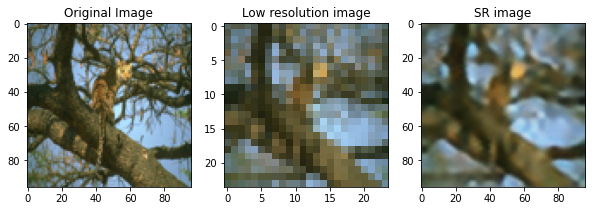

25/25 [==============================] - 8s 267ms/step - d_loss: 0.2385 - g_loss: 0.0920 - psnr: 23.8900 - val_d_loss: 0.2096 - val_g_loss: 0.1141 - val_psnr: 21.7322
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2259 - g_loss: 0.0912 - psnr: 23.9296

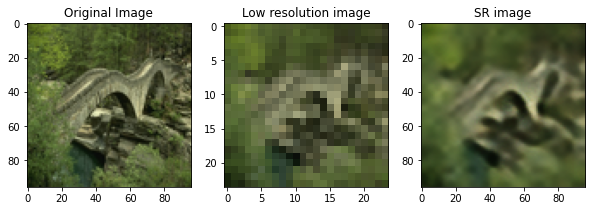

25/25 [==============================] - 8s 269ms/step - d_loss: 0.2259 - g_loss: 0.0912 - psnr: 23.9296 - val_d_loss: 0.2270 - val_g_loss: 0.1110 - val_psnr: 21.7492
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2123 - g_loss: 0.0925 - psnr: 23.8475

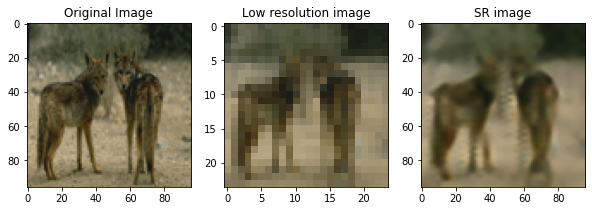

25/25 [==============================] - 8s 271ms/step - d_loss: 0.2123 - g_loss: 0.0925 - psnr: 23.8475 - val_d_loss: 0.2007 - val_g_loss: 0.1148 - val_psnr: 21.7252
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2061 - g_loss: 0.0918 - psnr: 23.9086

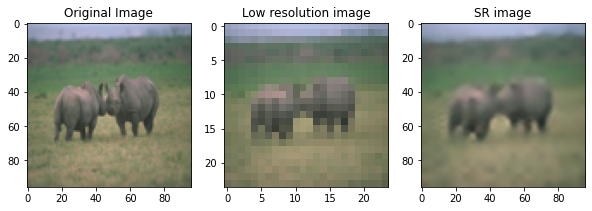

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2061 - g_loss: 0.0918 - psnr: 23.9086 - val_d_loss: 0.2011 - val_g_loss: 0.1166 - val_psnr: 21.6806
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2070 - g_loss: 0.0917 - psnr: 23.9214

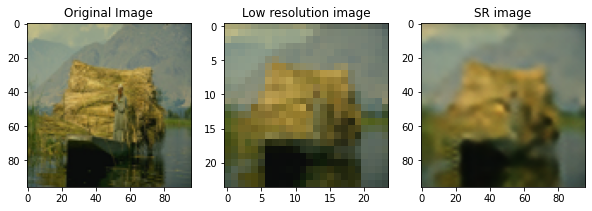

25/25 [==============================] - 8s 268ms/step - d_loss: 0.2070 - g_loss: 0.0917 - psnr: 23.9214 - val_d_loss: 0.2042 - val_g_loss: 0.1169 - val_psnr: 21.7541
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2050 - g_loss: 0.0915 - psnr: 23.9269

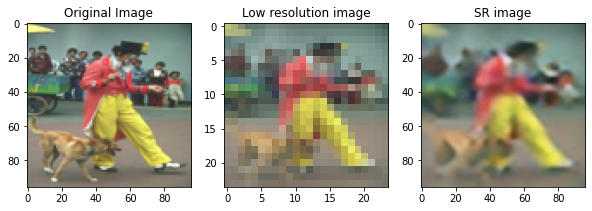

25/25 [==============================] - 8s 284ms/step - d_loss: 0.2050 - g_loss: 0.0915 - psnr: 23.9269 - val_d_loss: 0.2002 - val_g_loss: 0.1166 - val_psnr: 21.7529
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2082 - g_loss: 0.0917 - psnr: 23.9134

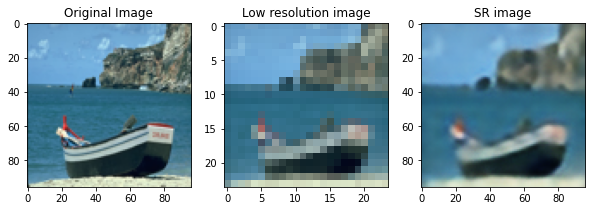

25/25 [==============================] - 8s 271ms/step - d_loss: 0.2082 - g_loss: 0.0917 - psnr: 23.9134 - val_d_loss: 0.2002 - val_g_loss: 0.1161 - val_psnr: 21.7689
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2050 - g_loss: 0.0926 - psnr: 23.8895

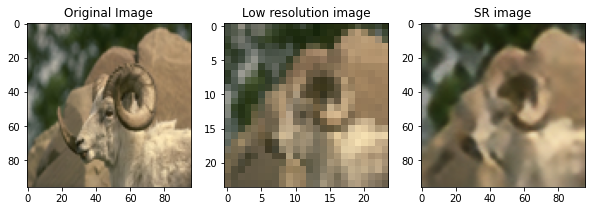

25/25 [==============================] - 8s 268ms/step - d_loss: 0.2050 - g_loss: 0.0926 - psnr: 23.8895 - val_d_loss: 0.1996 - val_g_loss: 0.1137 - val_psnr: 21.7097
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2020 - g_loss: 0.0919 - psnr: 23.9094

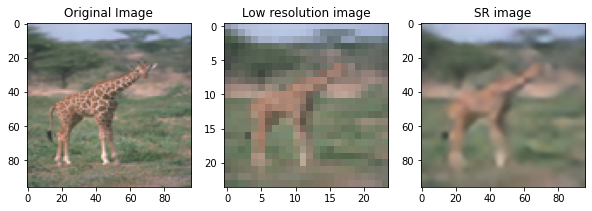

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2020 - g_loss: 0.0919 - psnr: 23.9094 - val_d_loss: 0.2011 - val_g_loss: 0.1166 - val_psnr: 21.7626
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2015 - g_loss: 0.0914 - psnr: 23.9266

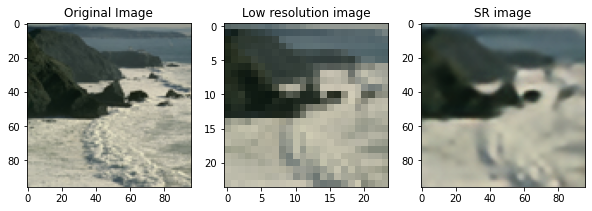

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2015 - g_loss: 0.0914 - psnr: 23.9266 - val_d_loss: 0.1993 - val_g_loss: 0.1112 - val_psnr: 21.7783
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2000 - g_loss: 0.0910 - psnr: 23.9665

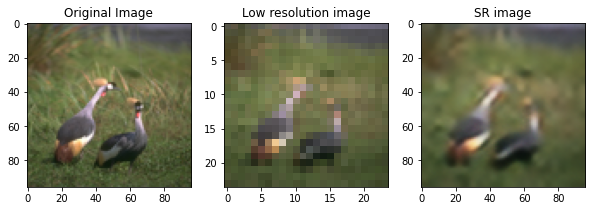

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2000 - g_loss: 0.0910 - psnr: 23.9665 - val_d_loss: 0.1992 - val_g_loss: 0.1190 - val_psnr: 21.7402
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2025 - g_loss: 0.0912 - psnr: 23.9459

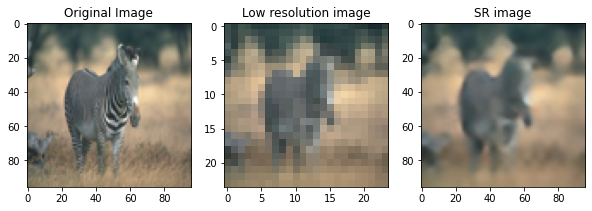

25/25 [==============================] - 8s 271ms/step - d_loss: 0.2025 - g_loss: 0.0912 - psnr: 23.9459 - val_d_loss: 0.1995 - val_g_loss: 0.1138 - val_psnr: 21.7772
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2025 - g_loss: 0.0918 - psnr: 23.9119

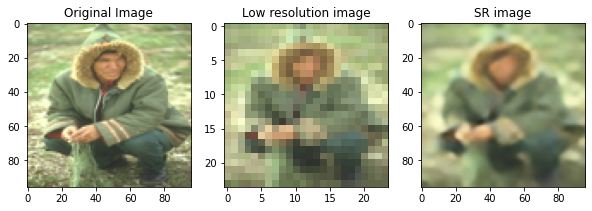

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2025 - g_loss: 0.0918 - psnr: 23.9119 - val_d_loss: 0.1997 - val_g_loss: 0.1155 - val_psnr: 21.7665
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2031 - g_loss: 0.0919 - psnr: 23.9283

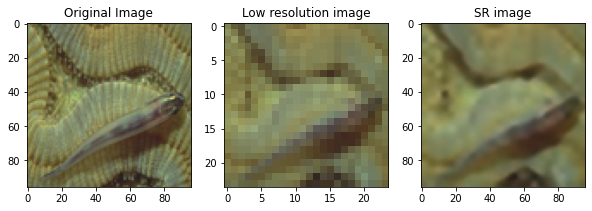

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2031 - g_loss: 0.0919 - psnr: 23.9283 - val_d_loss: 0.1989 - val_g_loss: 0.1112 - val_psnr: 21.7593
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2064 - g_loss: 0.0917 - psnr: 23.9390

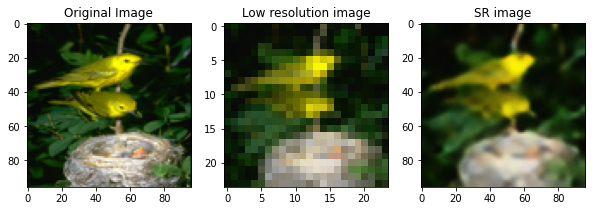

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2064 - g_loss: 0.0917 - psnr: 23.9390 - val_d_loss: 0.2072 - val_g_loss: 0.1134 - val_psnr: 21.7719
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2104 - g_loss: 0.0916 - psnr: 23.9279

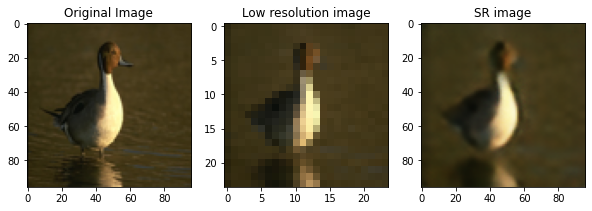

25/25 [==============================] - 8s 291ms/step - d_loss: 0.2104 - g_loss: 0.0916 - psnr: 23.9279 - val_d_loss: 0.2024 - val_g_loss: 0.1145 - val_psnr: 21.7556
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2165 - g_loss: 0.0924 - psnr: 23.8878

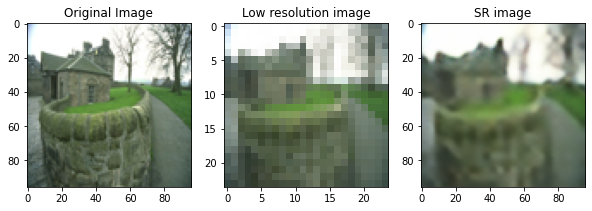

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2165 - g_loss: 0.0924 - psnr: 23.8878 - val_d_loss: 0.1999 - val_g_loss: 0.1175 - val_psnr: 21.7290
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2168 - g_loss: 0.0916 - psnr: 23.9304

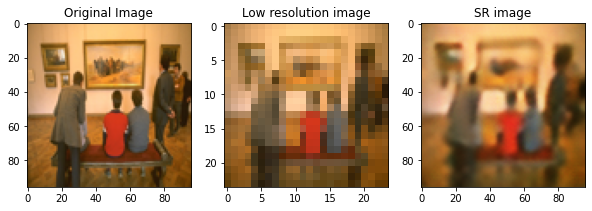

25/25 [==============================] - 8s 275ms/step - d_loss: 0.2168 - g_loss: 0.0916 - psnr: 23.9304 - val_d_loss: 0.2321 - val_g_loss: 0.1169 - val_psnr: 21.7676
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2089 - g_loss: 0.0912 - psnr: 23.9560

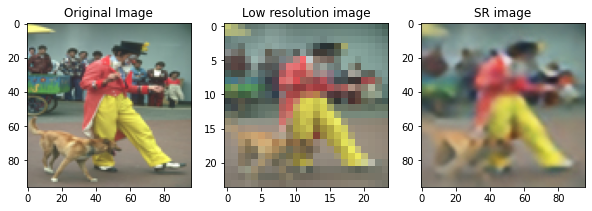

25/25 [==============================] - 8s 274ms/step - d_loss: 0.2089 - g_loss: 0.0912 - psnr: 23.9560 - val_d_loss: 0.2252 - val_g_loss: 0.1157 - val_psnr: 21.7666
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2037 - g_loss: 0.0918 - psnr: 23.9275

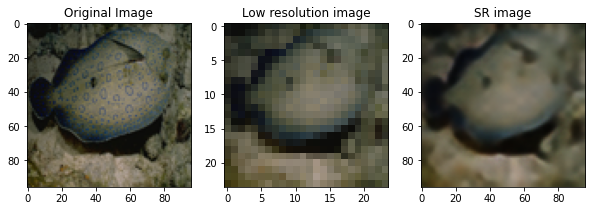

25/25 [==============================] - 8s 271ms/step - d_loss: 0.2037 - g_loss: 0.0918 - psnr: 23.9275 - val_d_loss: 0.1989 - val_g_loss: 0.1182 - val_psnr: 21.7793
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2027 - g_loss: 0.0932 - psnr: 23.8549

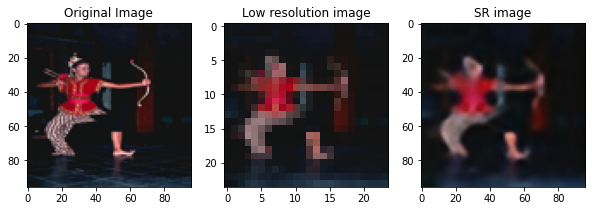

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2027 - g_loss: 0.0932 - psnr: 23.8549 - val_d_loss: 0.2030 - val_g_loss: 0.1175 - val_psnr: 21.7473
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2016 - g_loss: 0.0918 - psnr: 23.9247

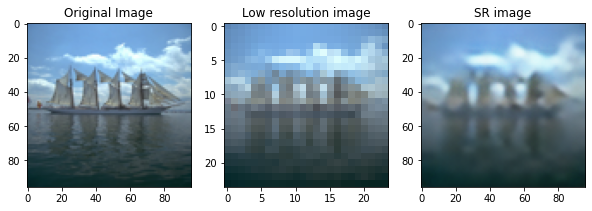

25/25 [==============================] - 8s 274ms/step - d_loss: 0.2016 - g_loss: 0.0918 - psnr: 23.9247 - val_d_loss: 0.1994 - val_g_loss: 0.1120 - val_psnr: 21.7793
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2029 - g_loss: 0.0908 - psnr: 23.9603

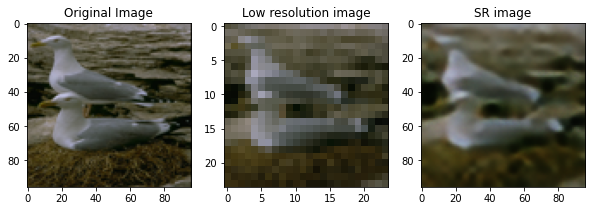

25/25 [==============================] - 8s 267ms/step - d_loss: 0.2029 - g_loss: 0.0908 - psnr: 23.9603 - val_d_loss: 0.2000 - val_g_loss: 0.1135 - val_psnr: 21.7879
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: 0.1995 - g_loss: 0.0909 - psnr: 23.9946

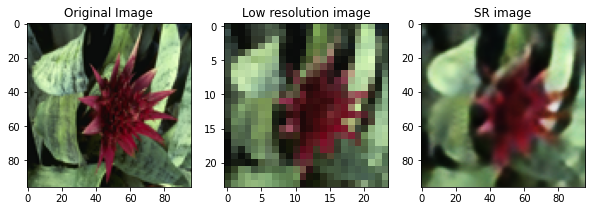

25/25 [==============================] - 8s 273ms/step - d_loss: 0.1995 - g_loss: 0.0909 - psnr: 23.9946 - val_d_loss: 0.1989 - val_g_loss: 0.1155 - val_psnr: 21.7995
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2015 - g_loss: 0.0905 - psnr: 24.0078

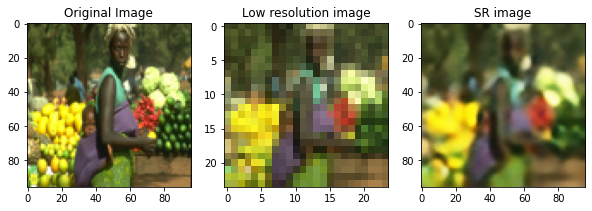

25/25 [==============================] - 8s 276ms/step - d_loss: 0.2015 - g_loss: 0.0905 - psnr: 24.0078 - val_d_loss: 0.2008 - val_g_loss: 0.1180 - val_psnr: 21.8011
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2041 - g_loss: 0.0905 - psnr: 23.9929

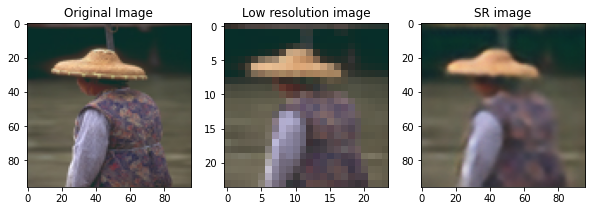

25/25 [==============================] - 8s 276ms/step - d_loss: 0.2041 - g_loss: 0.0905 - psnr: 23.9929 - val_d_loss: 0.1994 - val_g_loss: 0.1169 - val_psnr: 21.7950
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2003 - g_loss: 0.0900 - psnr: 24.0309

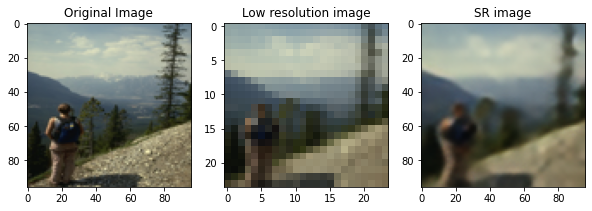

25/25 [==============================] - 8s 297ms/step - d_loss: 0.2003 - g_loss: 0.0900 - psnr: 24.0309 - val_d_loss: 0.2023 - val_g_loss: 0.1123 - val_psnr: 21.8053
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2023 - g_loss: 0.0904 - psnr: 23.9781

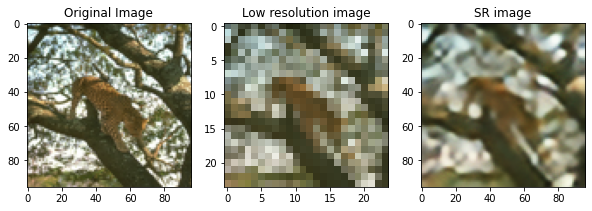

25/25 [==============================] - 8s 276ms/step - d_loss: 0.2023 - g_loss: 0.0904 - psnr: 23.9781 - val_d_loss: 0.1996 - val_g_loss: 0.1126 - val_psnr: 21.8109
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2013 - g_loss: 0.0903 - psnr: 24.0126

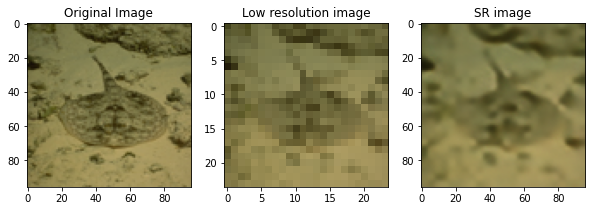

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2013 - g_loss: 0.0903 - psnr: 24.0126 - val_d_loss: 0.2007 - val_g_loss: 0.1147 - val_psnr: 21.7943
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2079 - g_loss: 0.0907 - psnr: 23.9921

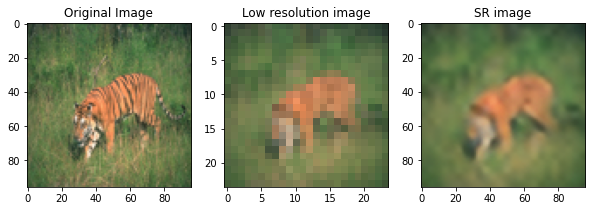

25/25 [==============================] - 8s 276ms/step - d_loss: 0.2079 - g_loss: 0.0907 - psnr: 23.9921 - val_d_loss: 0.2060 - val_g_loss: 0.1106 - val_psnr: 21.7940
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2013 - g_loss: 0.0905 - psnr: 24.0099

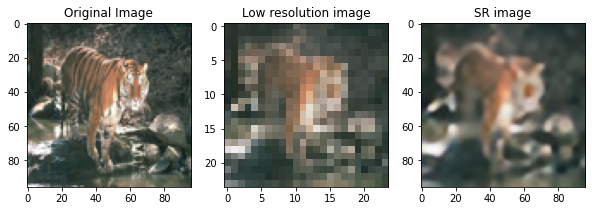

25/25 [==============================] - 8s 288ms/step - d_loss: 0.2013 - g_loss: 0.0905 - psnr: 24.0099 - val_d_loss: 0.1996 - val_g_loss: 0.1175 - val_psnr: 21.7992
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: 0.1991 - g_loss: 0.0906 - psnr: 23.9907

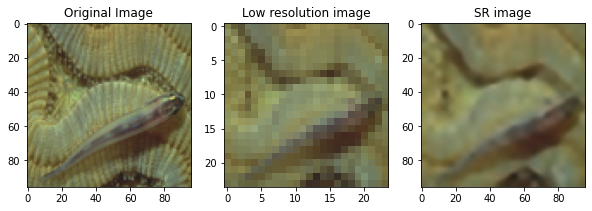

25/25 [==============================] - 8s 273ms/step - d_loss: 0.1991 - g_loss: 0.0906 - psnr: 23.9907 - val_d_loss: 0.1988 - val_g_loss: 0.1154 - val_psnr: 21.7763
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: 0.1997 - g_loss: 0.0905 - psnr: 24.0085

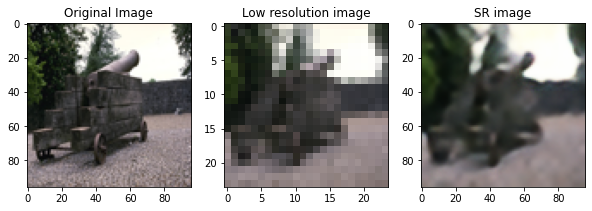

25/25 [==============================] - 8s 272ms/step - d_loss: 0.1997 - g_loss: 0.0905 - psnr: 24.0085 - val_d_loss: 0.1991 - val_g_loss: 0.1169 - val_psnr: 21.8025
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: 0.1996 - g_loss: 0.0910 - psnr: 23.9807

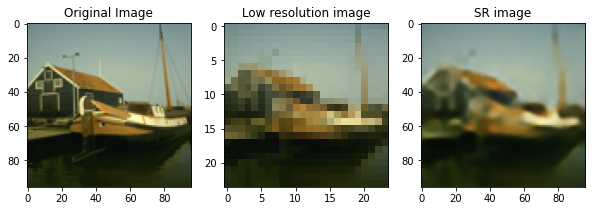

25/25 [==============================] - 8s 300ms/step - d_loss: 0.1996 - g_loss: 0.0910 - psnr: 23.9807 - val_d_loss: 0.1991 - val_g_loss: 0.1159 - val_psnr: 21.7946
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2010 - g_loss: 0.0909 - psnr: 23.9771

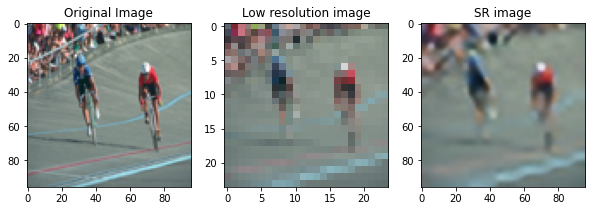

25/25 [==============================] - 8s 271ms/step - d_loss: 0.2010 - g_loss: 0.0909 - psnr: 23.9771 - val_d_loss: 0.1999 - val_g_loss: 0.1132 - val_psnr: 21.7633
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2613 - g_loss: 0.0914 - psnr: 23.9311

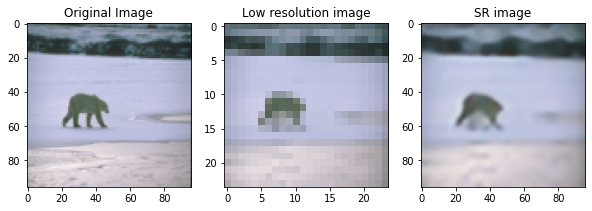

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2613 - g_loss: 0.0914 - psnr: 23.9311 - val_d_loss: 0.2194 - val_g_loss: 0.1150 - val_psnr: 21.8011
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2590 - g_loss: 0.0912 - psnr: 23.9380

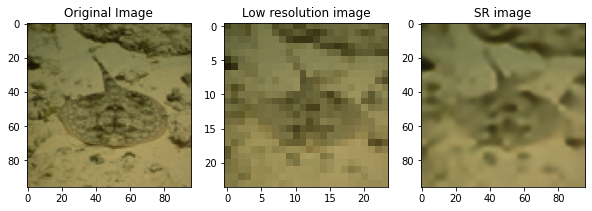

25/25 [==============================] - 8s 285ms/step - d_loss: 0.2590 - g_loss: 0.0912 - psnr: 23.9380 - val_d_loss: 0.2049 - val_g_loss: 0.1162 - val_psnr: 21.7840
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2194 - g_loss: 0.0908 - psnr: 23.9977

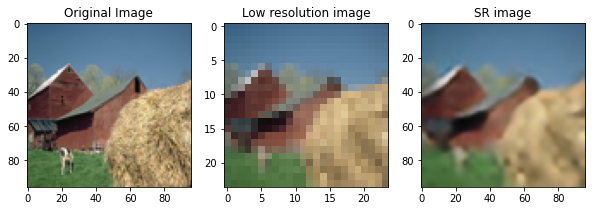

25/25 [==============================] - 8s 274ms/step - d_loss: 0.2194 - g_loss: 0.0908 - psnr: 23.9977 - val_d_loss: 0.2011 - val_g_loss: 0.1164 - val_psnr: 21.8042
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2054 - g_loss: 0.0904 - psnr: 24.0041

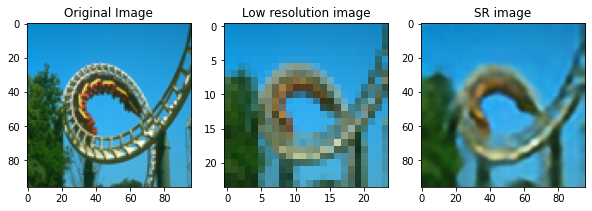

25/25 [==============================] - 8s 273ms/step - d_loss: 0.2054 - g_loss: 0.0904 - psnr: 24.0041 - val_d_loss: 0.1997 - val_g_loss: 0.1183 - val_psnr: 21.8156
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2027 - g_loss: 0.0899 - psnr: 24.0346

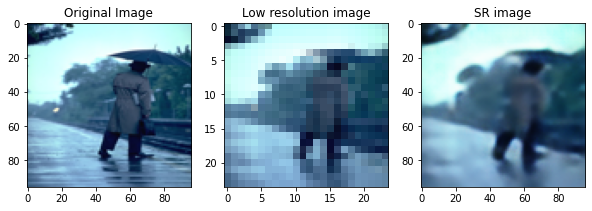

25/25 [==============================] - 8s 275ms/step - d_loss: 0.2027 - g_loss: 0.0899 - psnr: 24.0346 - val_d_loss: 0.1996 - val_g_loss: 0.1144 - val_psnr: 21.8092
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2044 - g_loss: 0.0903 - psnr: 24.0291

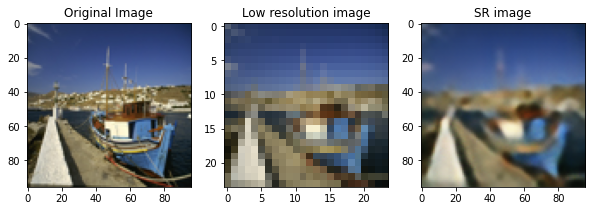

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2044 - g_loss: 0.0903 - psnr: 24.0291 - val_d_loss: 0.2054 - val_g_loss: 0.1126 - val_psnr: 21.7878
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2061 - g_loss: 0.0913 - psnr: 23.9695

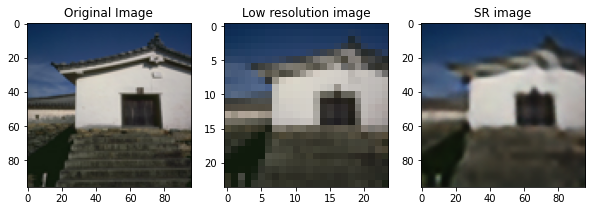

25/25 [==============================] - 8s 286ms/step - d_loss: 0.2061 - g_loss: 0.0913 - psnr: 23.9695 - val_d_loss: 0.2008 - val_g_loss: 0.1135 - val_psnr: 21.7921
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2028 - g_loss: 0.0909 - psnr: 23.9807

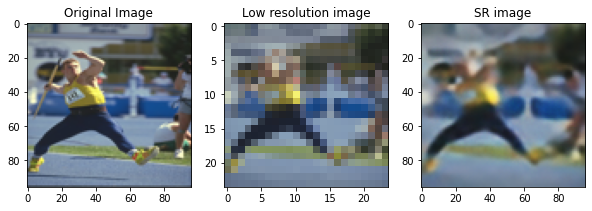

25/25 [==============================] - 8s 267ms/step - d_loss: 0.2028 - g_loss: 0.0909 - psnr: 23.9807 - val_d_loss: 0.1992 - val_g_loss: 0.1131 - val_psnr: 21.7893
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2039 - g_loss: 0.0905 - psnr: 24.0070

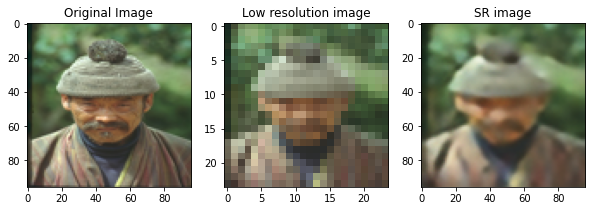

25/25 [==============================] - 8s 275ms/step - d_loss: 0.2039 - g_loss: 0.0905 - psnr: 24.0070 - val_d_loss: 0.1990 - val_g_loss: 0.1143 - val_psnr: 21.7974
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2016 - g_loss: 0.0906 - psnr: 24.0294

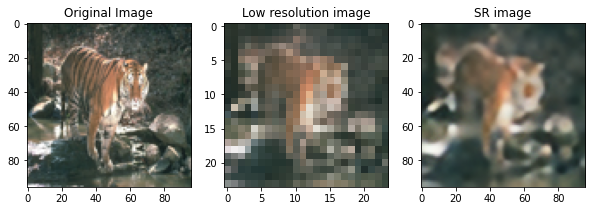

25/25 [==============================] - 8s 272ms/step - d_loss: 0.2016 - g_loss: 0.0906 - psnr: 24.0294 - val_d_loss: 0.1986 - val_g_loss: 0.1135 - val_psnr: 21.8159
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2028 - g_loss: 0.0898 - psnr: 24.0560

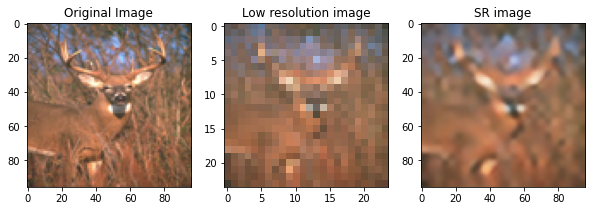

25/25 [==============================] - 8s 275ms/step - d_loss: 0.2028 - g_loss: 0.0898 - psnr: 24.0560 - val_d_loss: 0.1988 - val_g_loss: 0.1119 - val_psnr: 21.8004
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: 0.1995 - g_loss: 0.0905 - psnr: 24.0113

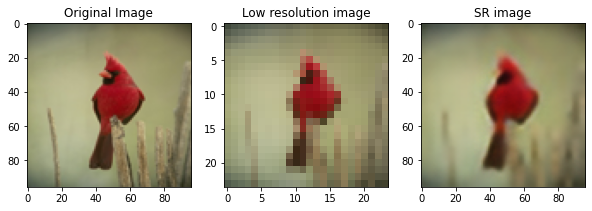

25/25 [==============================] - 8s 289ms/step - d_loss: 0.1995 - g_loss: 0.0905 - psnr: 24.0113 - val_d_loss: 0.1992 - val_g_loss: 0.1157 - val_psnr: 21.7659
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2038 - g_loss: 0.0908 - psnr: 23.9851

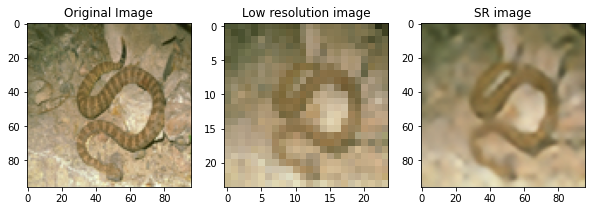

25/25 [==============================] - 8s 274ms/step - d_loss: 0.2038 - g_loss: 0.0908 - psnr: 23.9851 - val_d_loss: 0.1988 - val_g_loss: 0.1155 - val_psnr: 21.8114
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2115 - g_loss: 0.0903 - psnr: 24.0198

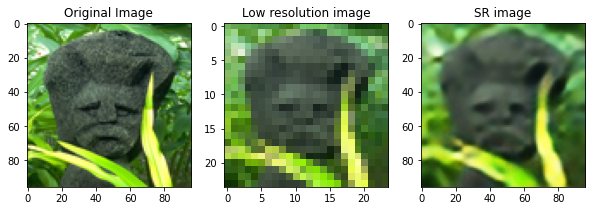

25/25 [==============================] - 8s 276ms/step - d_loss: 0.2115 - g_loss: 0.0903 - psnr: 24.0198 - val_d_loss: 0.1989 - val_g_loss: 0.1144 - val_psnr: 21.8149
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: 0.2267 - g_loss: 0.0901 - psnr: 24.0163

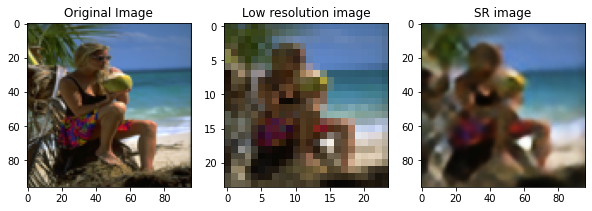

25/25 [==============================] - 8s 287ms/step - d_loss: 0.2267 - g_loss: 0.0901 - psnr: 24.0163 - val_d_loss: 0.2058 - val_g_loss: 0.1145 - val_psnr: 21.8103


In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=callbacks, verbose=1)

In [ ]:
# perceptual loss?
# more images, increase low resolution